In [1]:
# basics
import pandas as pd
import numpy as np

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [57]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,20))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

In [59]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    log_loss_score = log_loss(y_true, y_pred)
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    print('log loss', round(log_loss_score, 3))

## Baseline: One Versus Rest with LR

In [8]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


In [9]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [10]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [11]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.33203125
disgust_label precision: 0.6390977443609023
disgust_label recall 0.5985915492957746
disgust_label f1 0.6181818181818183


fear_label accuracy: 0.6389891696750902
fear_label precision: 0.8009049773755657
fear_label recall 0.8309859154929577
fear_label f1 0.815668202764977


joy_label accuracy: 0.5384615384615384
joy_label precision: 0.7368421052631579
joy_label recall 0.7253886010362695
joy_label f1 0.7310704960835509


sadness_label accuracy: 0.6819787985865724
sadness_label precision: 0.8109243697478992
sadness_label recall 0.8654708520179372
sadness_label f1 0.8373101952277657


surprise_label accuracy: 0.8900343642611683
surprise_label precision: 0.9184397163120568
surprise_label recall 0.9217081850533808
surprise_label f1 0.9200710479573712




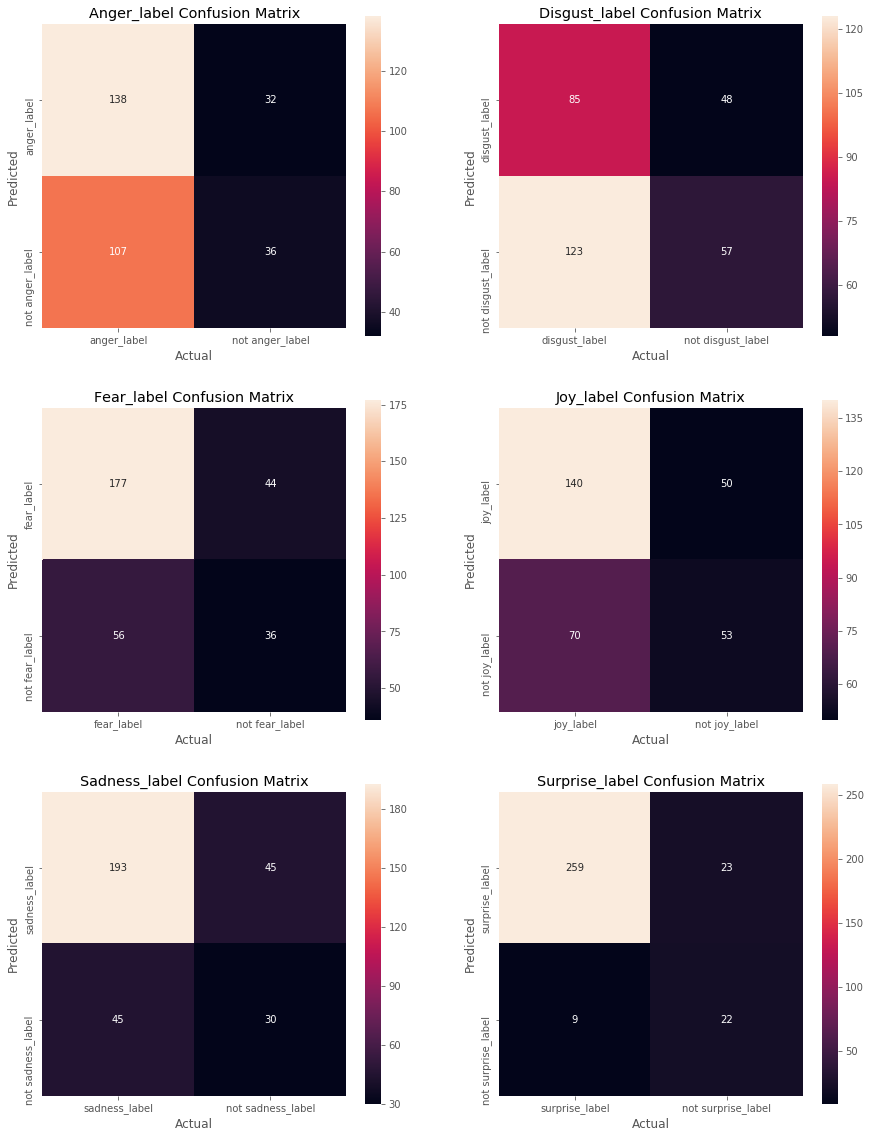

In [58]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [60]:
suite_of_scores(y_test, ovr_test_preds)


jaccard score average: 0.533
hamming loss: 0.4
f1 macro: 0.656
log loss 42.602


## Classifier Chain

In [15]:
import itertools
from sklearn.metrics import jaccard_score

np.random.seed=42
perms = list(itertools.permutations([0,1,2,3,4,5]))
random = np.random.choice(len(perms), size=720,)
perms_to_try = [perms[i] for i in random]

chains = [ClassifierChain(lr, order=perms_to_try[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [68]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.6660276890308839

In [69]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
#y _reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.5304054054054054
anger_label precision: 0.6596638655462185
anger_label recall 0.9022988505747126
anger_label f1 0.7621359223300971


disgust_label accuracy: 0.3522727272727273
disgust_label precision: 0.62
disgust_label recall 0.6549295774647887
disgust_label f1 0.6369863013698631


fear_label accuracy: 0.647887323943662
fear_label precision: 0.8070175438596491
fear_label recall 0.863849765258216
fear_label f1 0.834467120181406


joy_label accuracy: 0.5366795366795367
joy_label precision: 0.7554347826086957
joy_label recall 0.7202072538860104
joy_label f1 0.7374005305039788


sadness_label accuracy: 0.6370967741935484
sadness_label precision: 0.8272251308900523
sadness_label recall 0.7085201793721974
sadness_label f1 0.7632850241545894


surprise_label accuracy: 0.8865248226950354
surprise_label precision: 0.9090909090909091
surprise_label recall 0.8896797153024911
surprise_label f1 0.8992805755395683




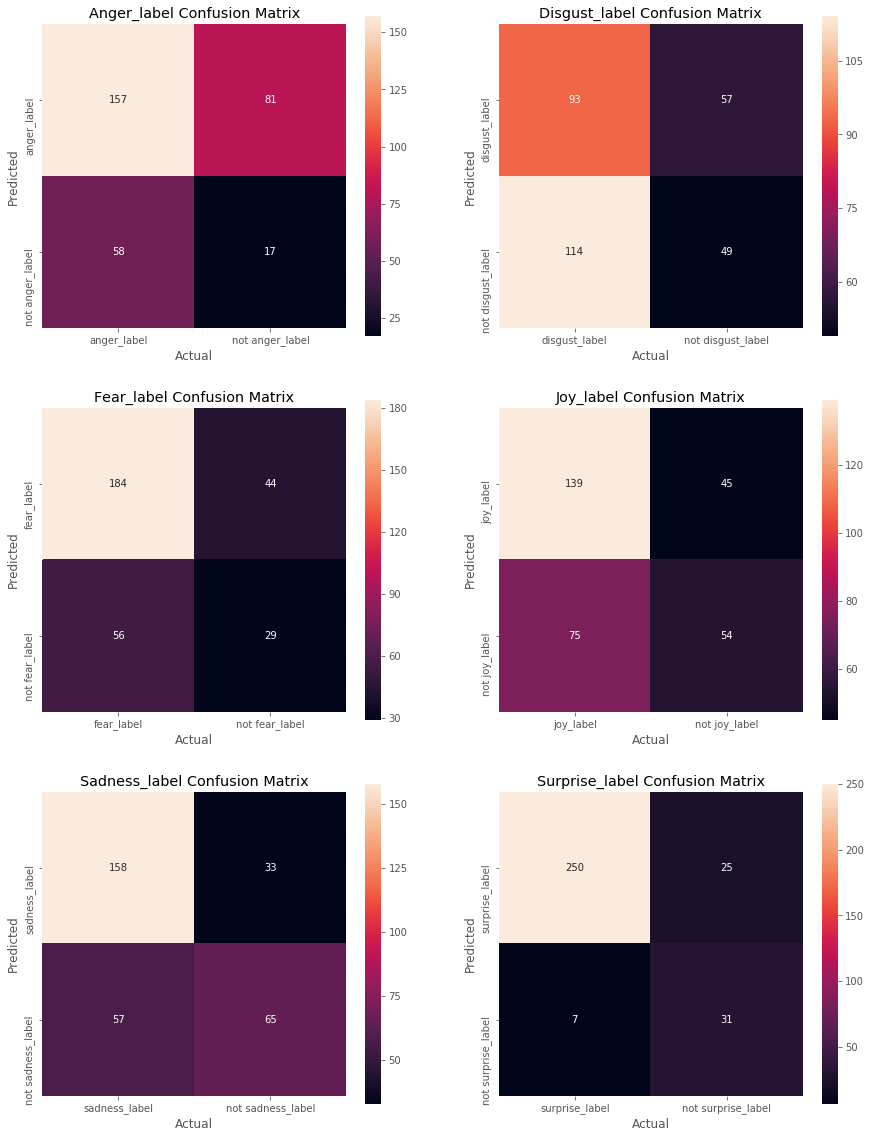

In [70]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [71]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.519
hamming loss: 0.426
f1 macro: 0.648
log loss 43.52


## Label Powerset Emotion Labels

In [63]:
lp = LabelPowerset(lr)

lp.fit(tf_idf_X_train, y_train)
lp_train_preds = lp.predict(tf_idf_X_train)
lp_test_preds = lp.predict(tf_idf_X_test)

In [64]:
LP_preds_df = pd.DataFrame(lp_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [65]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,1,1,1,1,0,0,1,1,1,1
1,0,0,1,1,1,1,0,0,1,1,1,1
2,0,0,0,1,0,1,0,0,1,0,1,1
3,0,0,0,1,1,1,0,1,1,0,0,1
4,0,0,1,1,0,1,1,1,1,1,1,1


anger_label accuracy: 0.38222222222222224
anger_label precision: 0.5341614906832298
anger_label recall 0.4942528735632184
anger_label f1 0.5134328358208955


disgust_label accuracy: 0.2629310344827586
disgust_label precision: 0.4357142857142857
disgust_label recall 0.4295774647887324
disgust_label f1 0.4326241134751773


fear_label accuracy: 0.5833333333333334
fear_label precision: 0.7070707070707071
fear_label recall 0.6572769953051644
fear_label f1 0.6812652068126521


joy_label accuracy: 0.5020746887966805
joy_label precision: 0.587378640776699
joy_label recall 0.6269430051813472
joy_label f1 0.606516290726817


sadness_label accuracy: 0.6296296296296297
sadness_label precision: 0.7251184834123223
sadness_label recall 0.6860986547085202
sadness_label f1 0.7050691244239632


surprise_label accuracy: 0.8873239436619719
surprise_label precision: 0.9130434782608695
surprise_label recall 0.896797153024911
surprise_label f1 0.9048473967684021




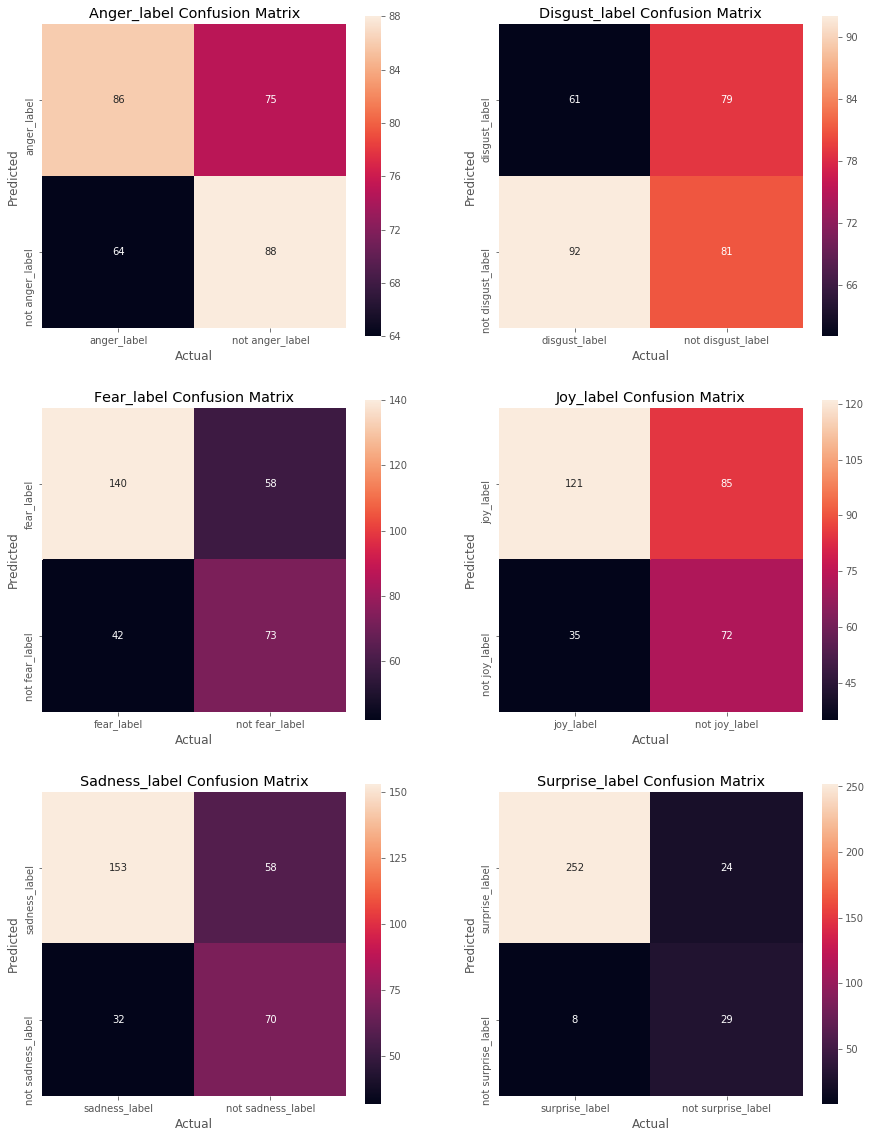

In [66]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


In [67]:
suite_of_scores(y_test, lp_test_preds.toarray())


jaccard score average: 0.502
hamming loss: 0.436
f1 macro: 0.618
log loss 48.153


## RNN for Multilabel Classification

In [32]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [33]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [34]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [37]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=1)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [44]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 3s 3ms/step - loss: 0.6857 - acc: 0.6258 - val_loss: 0.6765 - val_acc: 0.6677
Epoch 2/30
937/937 [==============================] - 0s 378us/step - loss: 0.4965 - acc: 0.7681 - val_loss: 0.5473 - val_acc: 0.7412
Epoch 3/30
937/937 [==============================] - 0s 367us/step - loss: 0.4209 - acc: 0.8173 - val_loss: 0.5485 - val_acc: 0.7167
Epoch 4/30
937/937 [==============================] - 0s 410us/step - loss: 0.3621 - acc: 0.8686 - val_loss: 0.5195 - val_acc: 0.7593
Epoch 5/30
937/937 [==============================] - 0s 367us/step - loss: 0.3054 - acc: 0.9000 - val_loss: 0.5406 - val_acc: 0.7476
Epoch 6/30
937/937 [==============================] - 0s 389us/step - loss: 0.2598 - acc: 0.9265 - val_loss: 0.5164 - val_acc: 0.7556
Epoch 7/30
937/937 [==============================] - 0s 366us/step - loss: 0.2170 - acc: 0.9502 - val_loss: 0.5090 - val_acc: 0.7609
Epoch 8/30
937/937

313/313 [==============================] - 0s 223us/step


[0.5960828566703552, 0.7577209889698333]

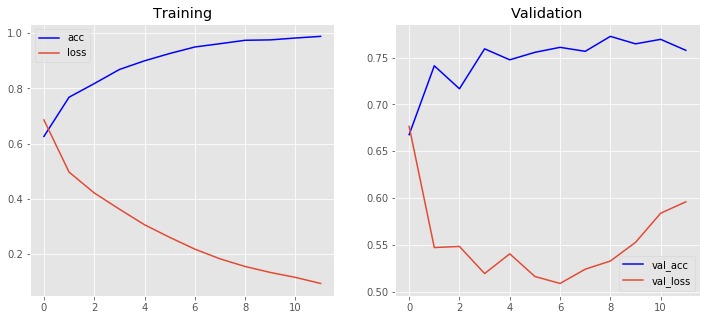

In [46]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [47]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.4404332129963899
anger precision: 0.7721518987341772
anger recall 0.7721518987341772
anger f1 0.7721518987341772


disgust accuracy: 0.3204225352112676
disgust precision: 0.6363636363636364
disgust recall 0.7583333333333333
disgust f1 0.6920152091254753


fear accuracy: 0.6063829787234043
fear precision: 0.7737556561085973
fear recall 0.8465346534653465
fear f1 0.8085106382978723


joy accuracy: 0.5680933852140078
joy precision: 0.8156424581005587
joy recall 0.7227722772277227
joy f1 0.7664041994750658


sadness accuracy: 0.6123188405797102
sadness precision: 0.8125
sadness recall 0.8203883495145631
sadness f1 0.8164251207729469


surprise accuracy: 0.8767605633802817
surprise precision: 0.9021739130434783
surprise recall 0.89568345323741
surprise f1 0.8989169675090252




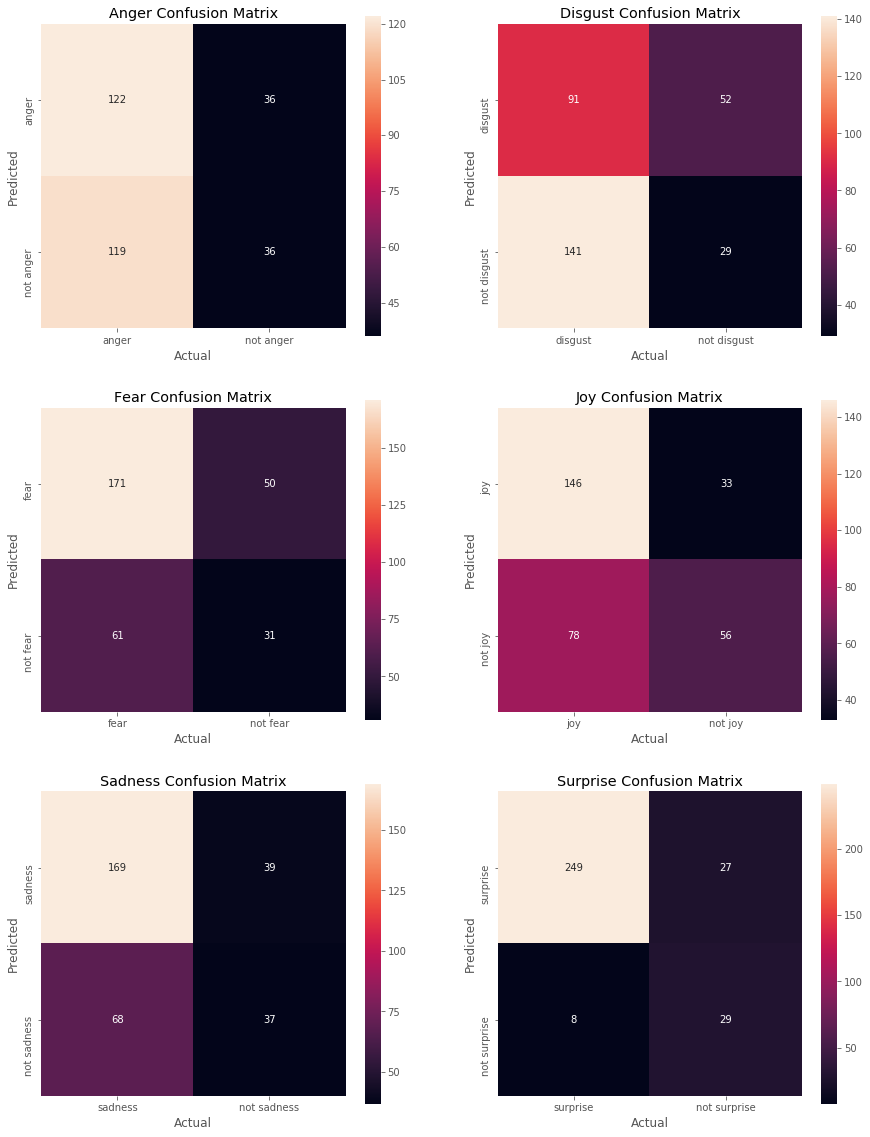

In [48]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [52]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.6919062832800852
jaccard score weighted: 0.6813669245111486
hamming loss: 0.2422790202342918
f1 macro: 0.7924040056524272
log loss: 28.234306754153195
